In [10]:
# -------------------------------------------------------------
# 1. Imports & Data Loading
# -------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import joblib

df = pd.read_csv("financial_news_events.csv", encoding="utf-8", engine="python")
print("Shape:", df.shape)
print(df.head())

Shape: (3024, 12)
         Date                                           Headline  \
0  2025-05-21        Nikkei 225 index benefits from a weaker yen   
1  2025-05-18  Government subsidy program gives a lift to the...   
2  2025-06-25  New housing data release shows a slowdown in m...   
3  2025-07-21  Massive stock buyback program announced by a c...   
4  2025-07-23  Government spending bill is expected to stimul...   

                    Source                Market_Event        Market_Index  \
0           Times of India       Commodity Price Shock                 DAX   
1          Financial Times        Central Bank Meeting  Shanghai Composite   
2  The Hindu Business Line  Consumer Confidence Report  Shanghai Composite   
3            The Economist       Commodity Price Shock           NSE Nifty   
4          The Motley Fool      Inflation Data Release    Nasdaq Composite   

   Index_Change_Percent  Trading_Volume Sentiment          Sector  \
0                  3.52          16

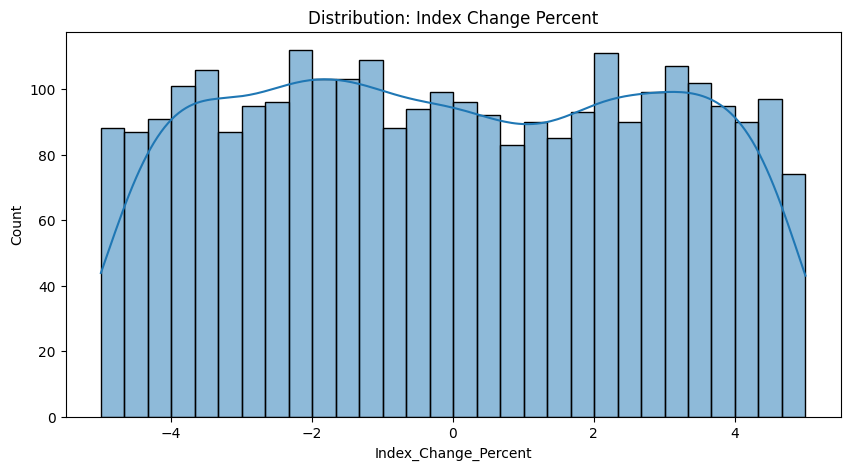

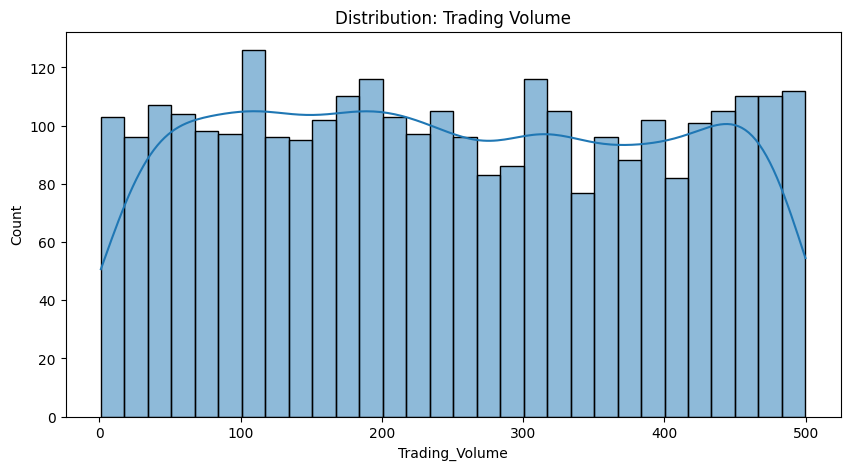

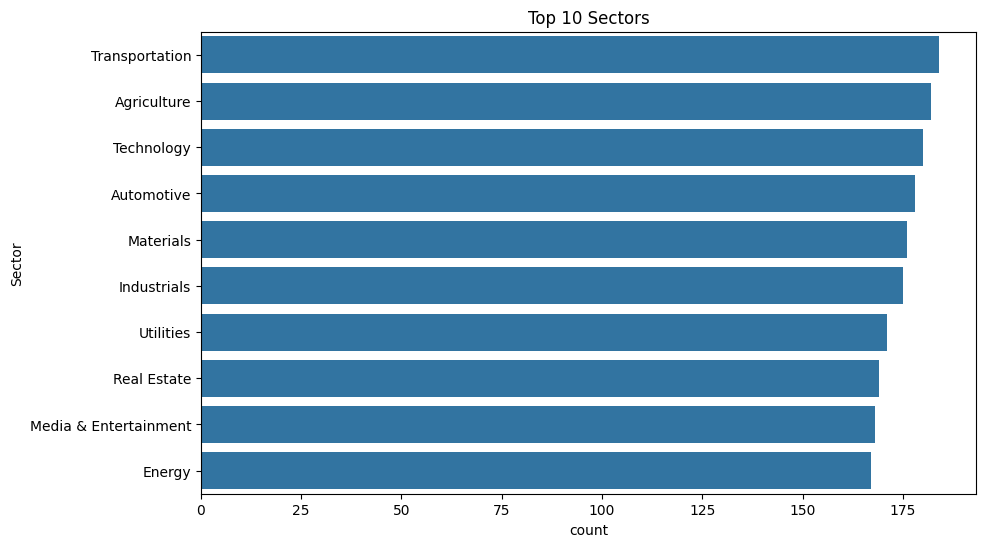

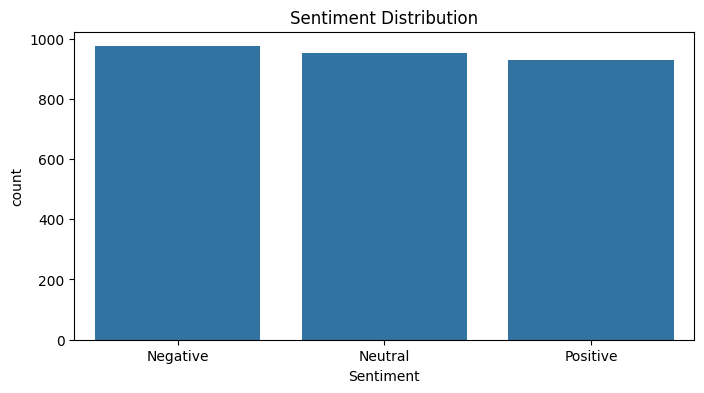

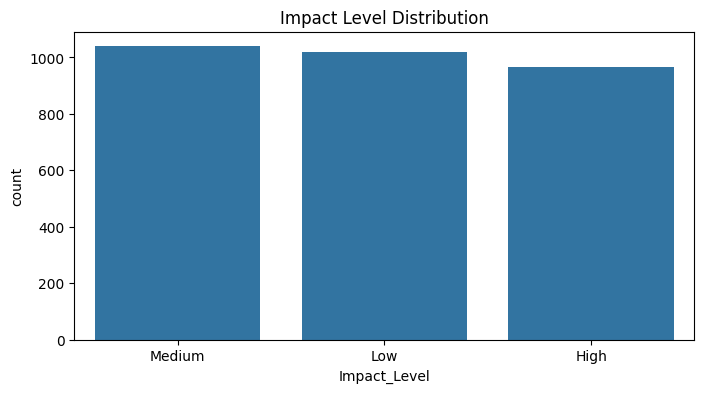

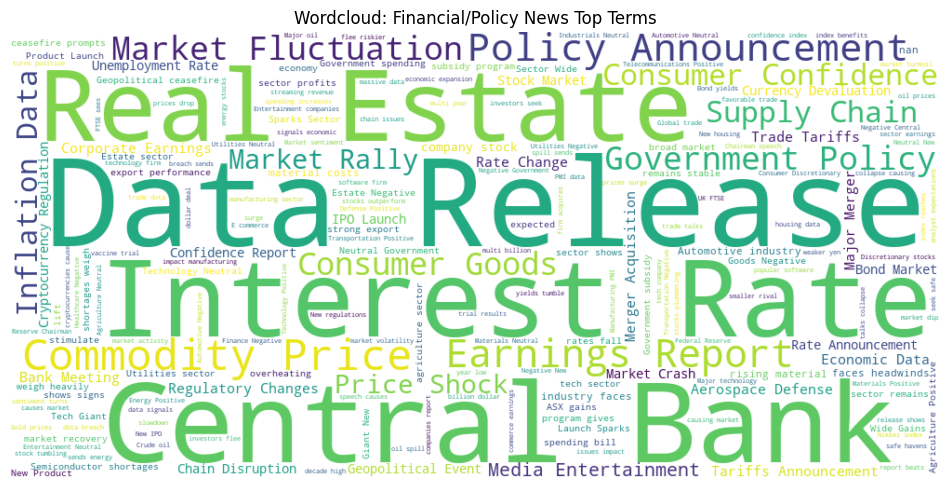

In [11]:
# -------------------------------------------------------------
# 2. EDA and Visualization (histograms, counts, wordcloud)
# -------------------------------------------------------------
df["Index_Change_Percent"] = pd.to_numeric(df["Index_Change_Percent"], errors="coerce")
df["Trading_Volume"] = pd.to_numeric(df["Trading_Volume"], errors="coerce")
df['Headline'] = df['Headline'].fillna("")

# Histograms
plt.figure(figsize=(10,5))
sns.histplot(df["Index_Change_Percent"].dropna(), bins=30, kde=True)
plt.title("Distribution: Index Change Percent")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df["Trading_Volume"].dropna(), bins=30, kde=True)
plt.title("Distribution: Trading Volume")
plt.show()

# Countplots
plt.figure(figsize=(10,6))
sns.countplot(y="Sector", data=df, order=df["Sector"].value_counts().index[:10])
plt.title("Top 10 Sectors")
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(x="Sentiment", data=df, order=df["Sentiment"].value_counts().index)
plt.title("Sentiment Distribution")
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(x="Impact_Level", data=df, order=df["Impact_Level"].value_counts().index)
plt.title("Impact Level Distribution")
plt.show()

# Wordcloud
df['market_text'] = (
    df['Headline']
    + " " + df['Market_Event'].astype(str)
    + " " + df['Sector'].astype(str)
    + " " + df['Sentiment'].astype(str)
)
text = " ".join(df['market_text'].values)
wc = WordCloud(width=1000, height=480, background_color="white").generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud: Financial/Policy News Top Terms")
plt.show()

In [12]:
# -------------------------------------------------------------
# 3. TF-IDF Vectorization, Model Training and Saving
# -------------------------------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
vectorizer.fit(df['market_text'])
tfidf_matrix = vectorizer.transform(df['market_text'])

# Save for later re-use
joblib.dump(vectorizer, "financial_news_vectorizer.pkl")
joblib.dump({'matrix': tfidf_matrix, 'df': df}, "financial_news_tfidf_matrix.pkl")
print("TF-IDF model and matrix saved!")

TF-IDF model and matrix saved!


In [13]:
# -------------------------------------------------------------
# 4. Model Loading & Semantic Search (Cosine Similarity)
# -------------------------------------------------------------
from sklearn.metrics.pairwise import cosine_similarity

# Load artifacts (simulate typical usage)
vectorizer = joblib.load("financial_news_vectorizer.pkl")
data = joblib.load("financial_news_tfidf_matrix.pkl")
tfidf_matrix = data["matrix"]
full_df = data["df"]

# Search function
def semantic_search(query, top_k=3):
    query_vec = vectorizer.transform([query.lower()])
    sims = cosine_similarity(query_vec, tfidf_matrix).flatten()
    full_df_copy = full_df.copy()
    full_df_copy["Similarity"] = sims
    top = full_df_copy.sort_values("Similarity", ascending=False).head(top_k)
    cols = ["Date","Headline","Market_Event","Sector","Sentiment","Impact_Level","Related_Company","Similarity"]
    return top[cols].reset_index(drop=True)

# EXAMPLE QUERY:
results = semantic_search("commodity price shock and government policy", top_k=3)
print("Top 3 results for query:")
print(results)

Top 3 results for query:
         Date Headline           Market_Event       Sector Sentiment  \
0  2025-05-31           Commodity Price Shock  Agriculture  Negative   
1  2025-04-13           Commodity Price Shock   Technology   Neutral   
2  2025-06-26           Commodity Price Shock  Industrials   Neutral   

  Impact_Level Related_Company  Similarity  
0         High       Microsoft    0.517783  
1          Low      Apple Inc.    0.510391  
2          Low       Microsoft    0.506590  


In [14]:
joblib.dump(vectorizer, "financial_news_vectorizer.pkl")
joblib.dump({'matrix': tfidf_matrix, 'df': df}, "financial_news_tfidf_matrix.pkl")

['financial_news_tfidf_matrix.pkl']